In [1]:
from dask.distributed import Client, LocalCluster
# import geopandas as gpd
# import networkx as nx
# from itertools import combinations
import dask
import numpy as np
from dask import delayed, dataframe as dd
import dask.array as da
import bokeh
import geopandas as gpd
from dask_ml.cluster import KMeans
import dask_geopandas as dgpd
from tqdm.notebook import tqdm
import pandas as pd
from shapely import Polygon
import json
import os
import glob
import matplotlib.pyplot as plt

/tmp/ipykernel_4029/2598064629.py:10: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [2]:
tessellation = gpd.read_parquet("./out/singapore/tessellation.pq")

<Axes: >

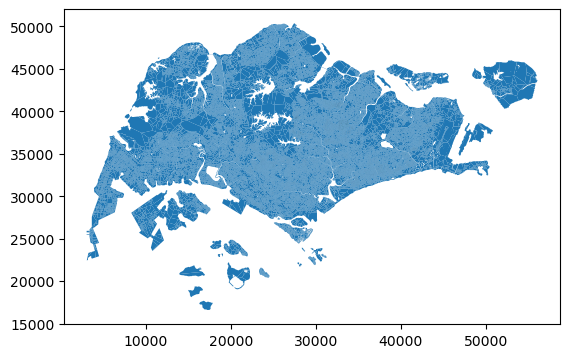

In [3]:
tessellation.plot()

In [4]:
# Init graph object
# G = nx.Graph()

In [5]:
# uID_list = tessellation["uID"].unique()

# for uid in np.sort(uID_list):
#     G.add_node(uid)

In [6]:
# Load the tessellation as a Dask dataframe
# tessellation_dd = dd.from_pandas(tessellation, npartitions=24)

In [7]:
# # define a function to process every pair
# def process_pair(pair):
#     # do something with the pair of rows

#     out = (int(pair[0]["uID"]), int(pair[1]["uID"]))
#     print(out)
#     return out
#     # if x_geom.touches(y_geom):
#     #     G.add_edge(pair[0]["uID"], pair[1]["uID"])
#     # elif x_geom.intersects(y_geom):
#     #     G.add_edge(pair[0]["uID"], pair[1]["uID"])

# pairs = []

# # iterate through every pair of rows in the Dask dataframe
# pairs = tessellation_dd.compute().index.tolist()
# for i, j in combinations(pairs, 2):
#     # get the rows of the two indices
#     row1 = tessellation_dd.loc[i].compute()
#     row2 = tessellation_dd.loc[j].compute()

#     # do something with the pair of geometries
#     pair = process_pair((row1, row2))
    
#     # append the pair to the list
#     pairs.append(pair)

In [8]:
Daskcluster = LocalCluster(threads_per_worker=2,
                n_workers=8, memory_limit='100GB')

client = Client(Daskcluster)
client

2023-04-12 15:23:19,639 - distributed.worker_memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 15.58 GiB
2023-04-12 15:23:19,642 - distributed.worker_memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 15.58 GiB
2023-04-12 15:23:19,644 - distributed.worker_memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 15.58 GiB
2023-04-12 15:23:19,647 - distributed.worker_memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 15.58 GiB
2023-04-12 15:23:19,649 - distributed.worker_memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 15.58 GiB
2023-04-12 15:23:19,652 - distributed.worker_memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 15.58 GiB
2023-04-12 15:23:19,654 - distributed.worker_memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 15.58 GiB
2023-04-12 15

<Client: 'tcp://127.0.0.1:46019' processes=8 threads=16, memory=124.66 GiB>

In [9]:
# Assuming 'tessellation' is a GeoDataFrame with a 'geometry' column
# Convert the GeoDataFrame to a Dask GeoDataFrame
dask_tessellation = dd.from_pandas(tessellation, npartitions=16)

In [10]:
x_coords = dask_tessellation.geometry.centroid.x.to_dask_array(lengths=True)
y_coords = dask_tessellation.geometry.centroid.y.to_dask_array(lengths=True)

# Concatenate x and y coordinates along the second axis
coords = da.concatenate([x_coords[:, None], y_coords[:, None]], axis=1)

# Rechunk the coords array along the first axis only
coords = coords.rechunk({0: -1, 1: coords.shape[1]})

print(coords.compute())

/home/virgilxw/miniconda3/lib/python3.10/site-packages/distributed/protocol/pickle.py:73: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  return pickle.loads(x)
/home/virgilxw/miniconda3/lib/python3.10/site-packages/distributed/protocol/pickle.py:73: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still us

[[42428.49413674 33521.08512412]
 [42965.18954383 33828.50904263]
 [42545.9651526  33777.13421521]
 ...
 [ 3645.31604908 27093.92258102]
 [ 3171.57134114 25500.00716747]
 [ 3130.39684791 25818.32293113]]


In [11]:
n_clusters = int(len(tessellation) / 12000) # compute the number of clusters needed
print(n_clusters)

6


In [12]:
def my_kmeans (n_clusters, coords):

    # Train the KMeans estimator with 100 clusters
    kmeans = KMeans(n_clusters)

    # Fit the KMeans estimator to the data
    kmeans.fit(coords)

    # Predict the clusters of the data points
    labels = kmeans.predict(coords)

    labels_np = labels.compute()

    tessellation["cluster"] = labels_np
    
    return tessellation

In [13]:
tessellation = my_kmeans(n_clusters, coords)

/home/virgilxw/miniconda3/lib/python3.10/site-packages/dask/base.py:1367: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(


<Axes: >

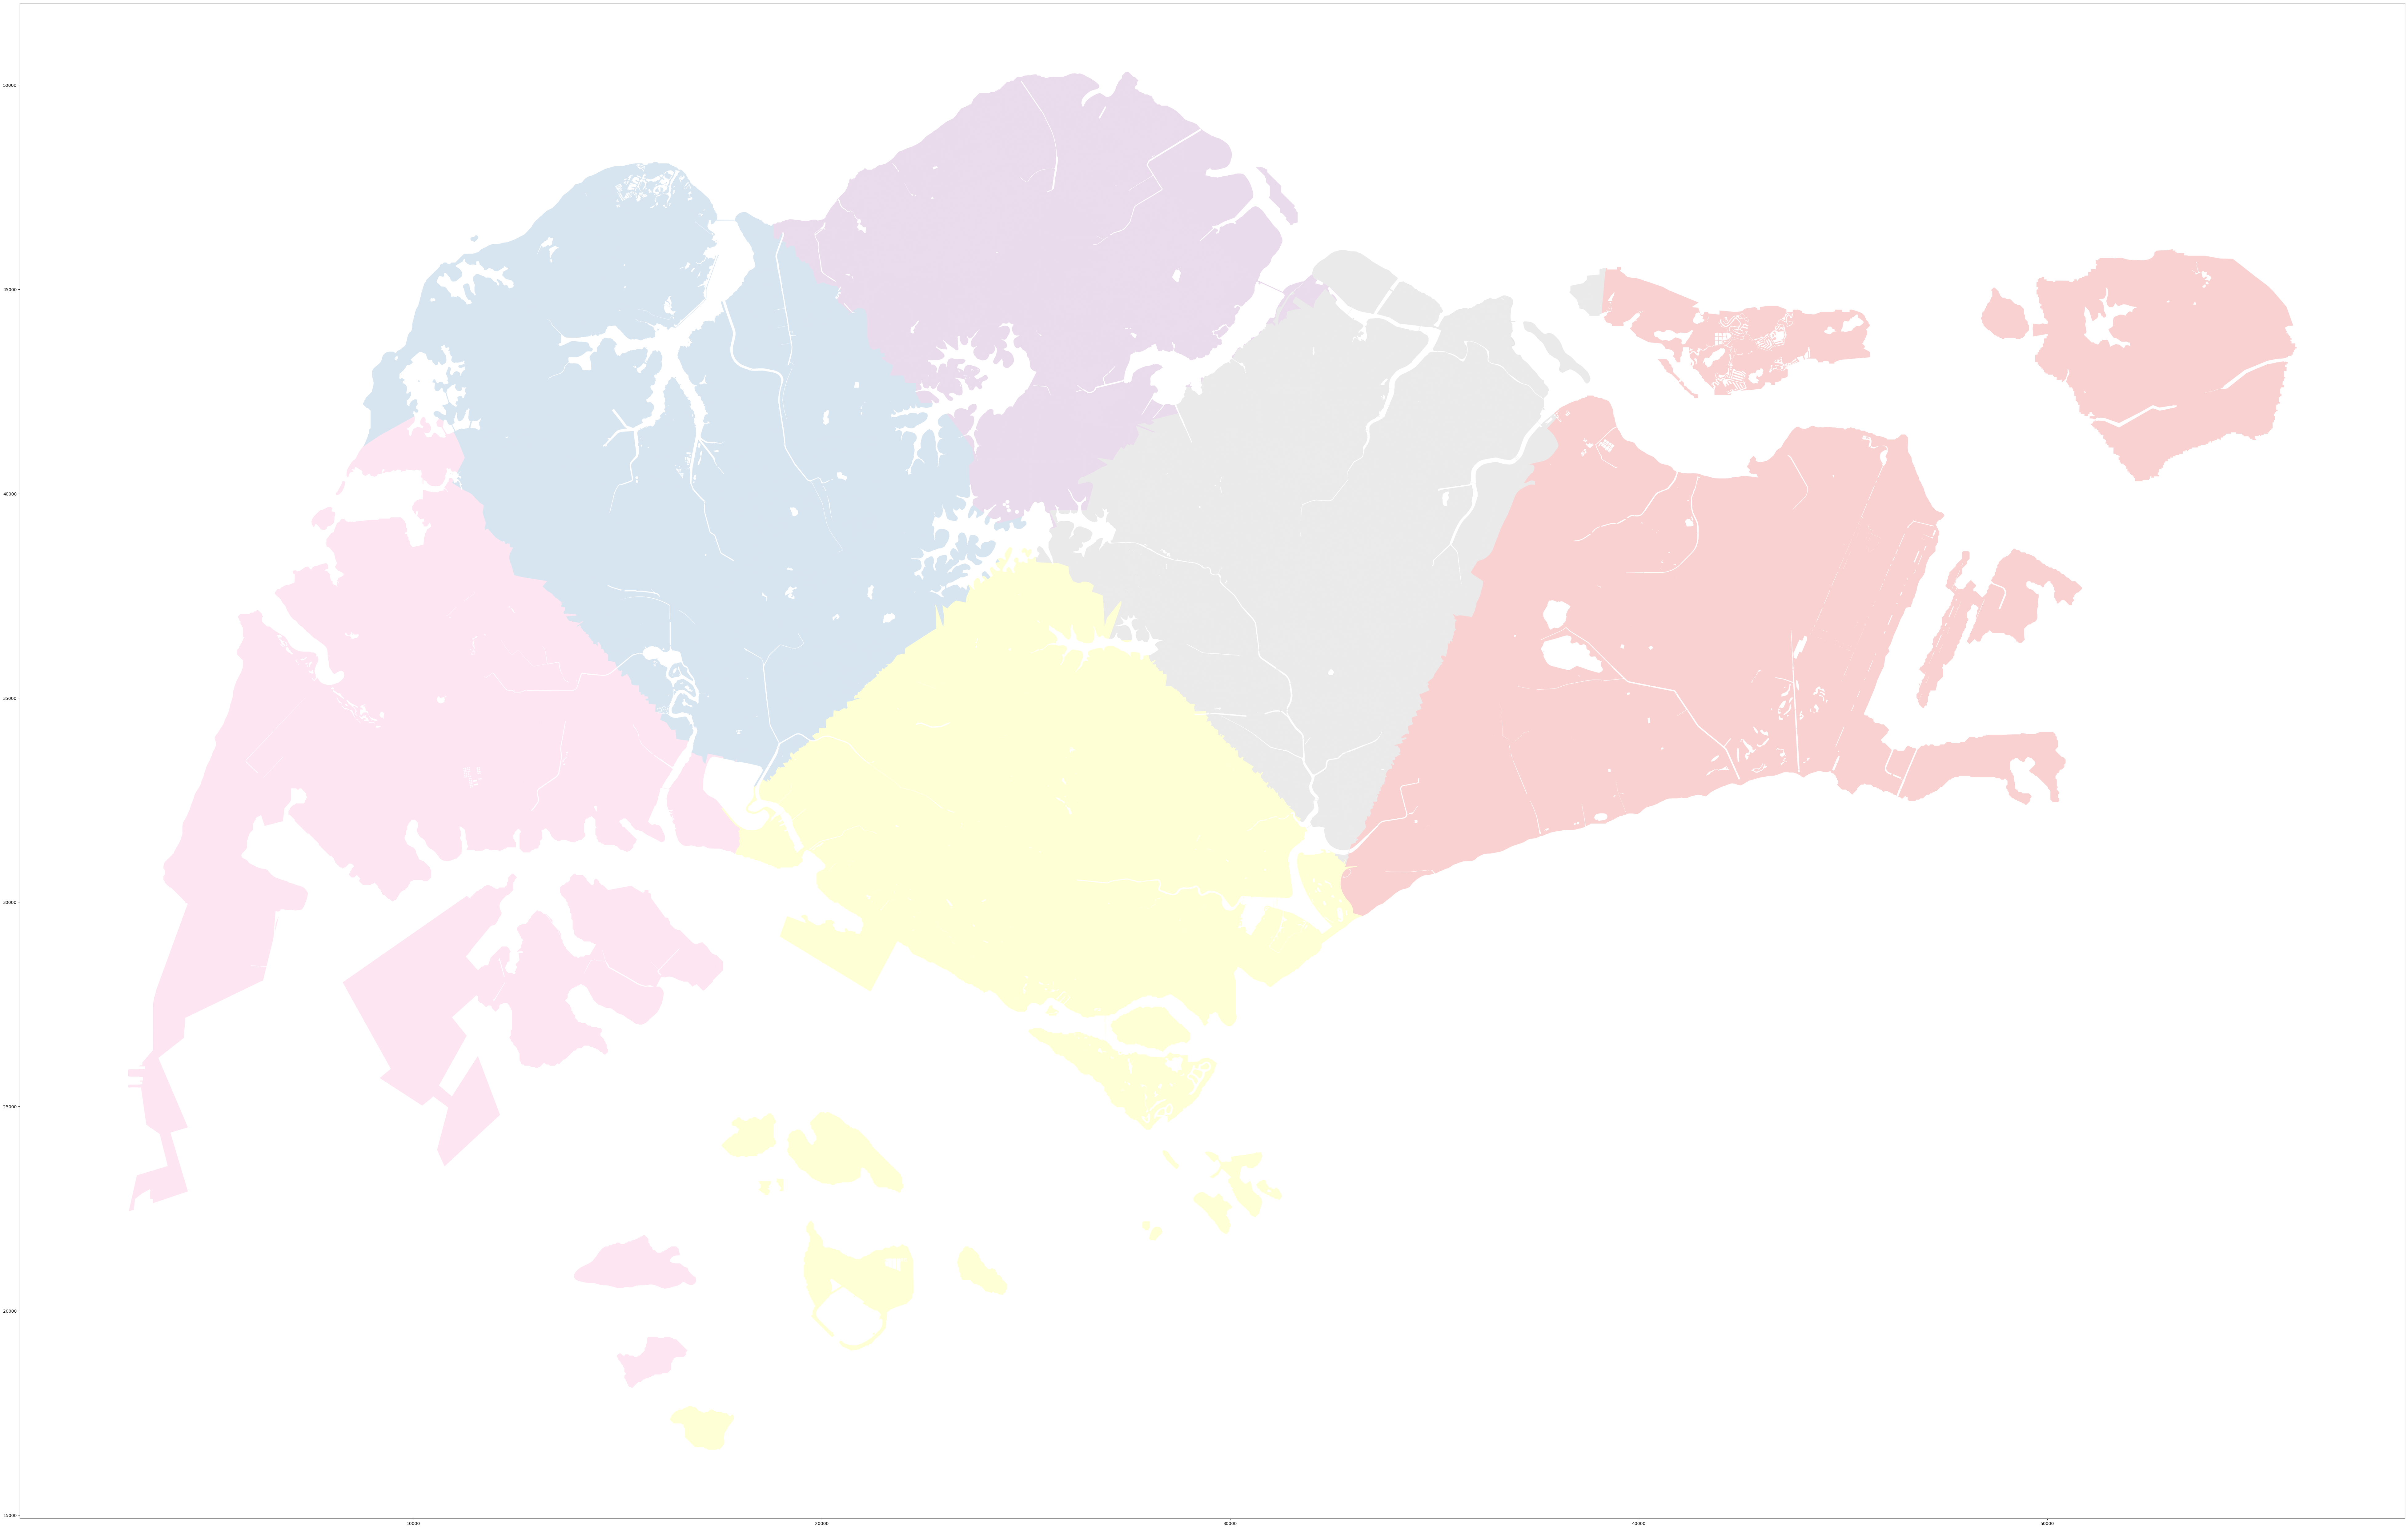

In [14]:
# Specify the column to use for color and colormap
column = 'cluster'
cmap = 'Set1'

# Plot the GeoDataFrame with colors determined by the 'cluster' column
tessellation.plot(column=column, cmap=cmap, figsize=(100, 100), alpha=0.2)

In [15]:
# Assume `gdf` is a GeoDataFrame
tessellation_grouped = tessellation.groupby('cluster')
cluster_list = [cluster for cluster in tessellation_grouped]

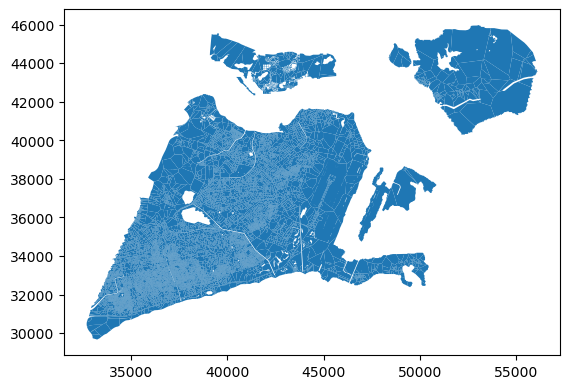

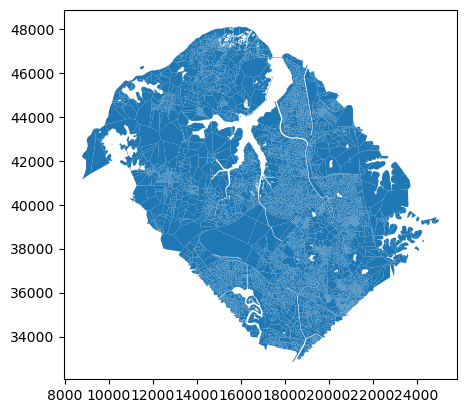

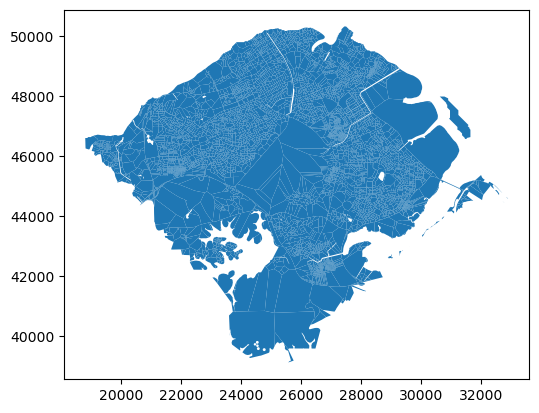

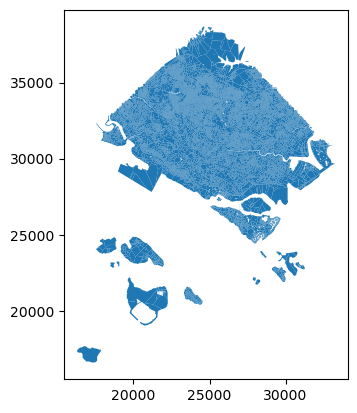

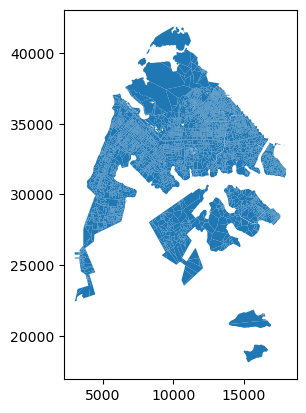

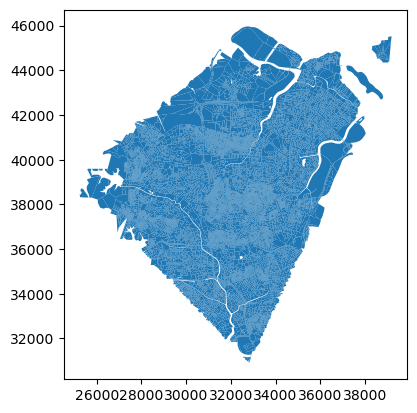

In [16]:
for index, gdf in cluster_list:
    gdf.plot()

In [17]:
Daskcluster.close()
client.shutdown()

In [18]:
cluster = tessellation.dissolve(by="cluster")
cluster.to_parquet("./out/singapore/cluster_dissolved.pq")

2023-04-12 15:30:12,638 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


In [19]:
file_pattern = "./out/singapore/tess_cells_in_cluster_*.pq"
file_list = glob.glob(file_pattern)

for file_path in file_list:
    if os.path.exists(file_path):
        os.remove(file_path)

for index, cluster in cluster_list:
    cluster.to_parquet(f"./out/singapore/tess_cells_in_cluster_{index}.pq")

In [20]:
includes_dict = dict()
for i in range(n_clusters):
    includes_dict[i] = []

for index, row in tqdm(tessellation.iterrows(), total=tessellation.shape[0]):
    
    includes_dict[row["cluster"]].append(row["uID"])

file_path = "./out/singapore/what_cells_are_in_what_cluster_dict.json"

if os.path.exists(file_path):
    os.remove(file_path)

with open(file_path, 'x') as f:
    json.dump(includes_dict, f)

  0%|          | 0/83424 [00:00<?, ?it/s]

In [21]:
tessellation.to_parquet(f"./out/singapore/all_test.pq")

: 